# Prediction Challenge
This notebook contains our attempt to predict `CO2 Emissions per Capita (metric tonnes)` for each city. The notebook consist of three parts 
* Part 0: **Model Preparation** 
> This part will consist of the preparations before any modeling occur. Here missing values will be considered more precisely whether they should be imputed or excluded. In this part, it will be argued for our choice of model as well as how we test to validate it. 
 we will bring up the theory for creating a great model 
* Part 1: **Prediction Challenge 1**
> In this part the first prediction challenges will be considered. That is the training set will consist of the first 75 % row and the remaining 25% rows will act as the test set. The
* Part 2: **Prediction Challenge 2** 
>In this part the second prediction challenges will be considered. That is the rows with corresponding cities in North and South America will act as the test set while the remaining rows with cities elsewhere will act as the training set.
* Part 3: **Trying out other regression models**
> In this part we will consider other regression models that are implemented in the Sklearn library. Here only the first prediction challenge will be considered as this part will mainly act to show how powerful the library is and how easy to try a different model with the framework. 

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import linear_model
from sklearn.metrics import r2_score

## Part 0.1: Choice of model - Elastic Net


Get rid of irrelevant variables/select important variables (lasso)

Works well when covariates are highly correlated; allows us to “average” highly correlated features and obtain more robust estimates (grouping features).

## Part 0.2: Setting up Sklearn modelling tools 

Subtract mean and standardize variance on all variables before applying any regularization techniques!

When you have obtained the optimal regularization parameters and evaluated performance you should build one final model on all data

When fitting statistical models there are parameters to tune and choices to make


training set
Used to build different models, e.g. with different values of the tuning parameter λ.
Validation set
ˆ
Used to calculate EPE for the different models and select the best, i.e. used to tune parameters, select features and similar modeling decisions. Also called dev (development) set, or hold-out cross validation set.
Test set
Used to estimate/test how well the resulting model performs, i.e. evaluate performance of algorithm, but make no decisions based on this data.


Cross-validation
Often there is insufficient data to create a separate validation and test set. In this instance use cross validation instead.
Cross-validation:
The primary method for estimating a tuning parameter, e.g. λ. No underlying assumptions
􏰀 Except, that observations are assumed to be independent. Is simple, intuitive and easy to implement


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

In [3]:

def negeate_MSE(y_true, y_pred):
    mse = -mean_squared_error(y_true, y_pred)
    return mse


def cv(pipe, parameters, X_train, y_train, cf = 10):    
    # perform cross validaiton over the input parameters
    cv_select = GridSearchCV(
        estimator=pipe, 
        param_grid=parameters, 
        scoring=make_scorer(negeate_MSE),
        n_jobs=-1,
        return_train_score=True,
        verbose=10, 
        cv=cf
    )
    cv_select.fit(X_train, y_train)
    
    return(cv_select)

def getPipe(model, numerical_columns, categorical_columns):

    # Pipeline to handle continous parameters. Here the parameters are scaled 
    numeric_transformer = Pipeline([
        ('scale', StandardScaler())
    ])
    
    # Pipeline to handle categorical parameters. Here the categorical variables
    # which are missing is imputed by using the most frequent value
    # afterwards they are one-hot encoded.
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(
            missing_values = ' NaN',
            strategy = 'most_frequent')),
        ('hot', OneHotEncoder())
    ])
    
    # Split the data into continous and caterigorical using ColumnTransformer
    # and apply numeric_transformer and categorical_transformer 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='drop'
    )
    
    # Build the final pipeline for model fitting
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipe



## Part 1: Prediction Challenge 1

In [5]:
df = pd.read_csv(os.path.abspath('../data/Processed/Cities_imputed.csv'), index_col=0)

Now the data will be splitted into predictors: $\mathbf{X}$ and targets: $\mathbf{y}$. The below function ensures that job. Furthermore the function takes an aditional argument `drop_cols` which is used to delete a list of selected column(s). It will be utilzed to make sure that column **Pollution index** does not play a part in the modelling. 

In [6]:
def split_target_and_predictors(data, target, drop_cols = []):
    X = data.drop(drop_cols+[target], axis = 1)
    y = data[[target]]

    return X, y

X, y = split_target_and_predictors(
    data = df,
    target = 'CO2_Emissions_per_Capita_(metric_tonnes)',
    drop_cols = ['Pollution_Index_']
)

Now to split the data into a test a training set where the first 75% row will corrosponds to train and last 25% row will corrosponds to test test. We utilize `sklearn` function `train_test_split` from the `model_selection` module. Note here the two function arguments test_size = 0.25, and `shuffle = False`.  The first argument ensure that the testing set will take the size of 25% and hence the training set will take the size of 75%. The second keyword ensure that the dataset is not shuffled. By default the first rows will corrospond to train and the remaing to test. 

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.25, shuffle = False)

bla bla bla bla

In [19]:
colum_names = X_train.columns

no_info_column = ['City', 'cityID', 'clusterID', 'Country', 'Latitude', 'Longitude', 'Typology', 'Continent']

columns_with_nan = df.columns[df.isnull().any()].tolist()
remove_columns = no_info_column + columns_with_nan

categorical_columns = []
numerical_columns = [ column for column in colum_names if column not in remove_columns+categorical_columns ]




Works well when covariates are highly correlated; allows us to “average” highly correlated features and obtain more robust estimates (grouping features).


In [20]:
elastic_net_model = linear_model.ElasticNet(fit_intercept = True)

parameters = {
    'model__alpha': np.logspace(-5, 1, 50),
    'model__l1_ratio': np.linspace(0, 1, 10)
}

elastic_net_pibe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
    categorical_columns = categorical_columns
)
elastic_net_cv = cv(elastic_net_pibe, parameters, X_train, y_train, cf = 10)


Fitting 10 folds for each of 500 candidates, totalling 5000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1998s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 228 

In [21]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()

In [22]:
elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]

0.01151395399326447

In [23]:
elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

0.6666666666666666

In [24]:
y_pred = elastic_net_cv.predict(X_test)
print('R2: ', r2_score(y_test, y_pred))

R2:  0.652055784630797


### Part 1.1 Coefficients Analysis

In [ ]:
def plot_coef(model, df):
    # get the column transformer object from the pipe object:
    ColumnTransformer = model.get_params()['estimator__steps'][0][1]

    # exstract the numerical and categorical columns
    numerical_features = ColumnTransformer.transformers[0][2]
    categorical_features = ColumnTransformer.transformers[1][2]

    # One hot encode the the names if there is categorical columns
    if categorical_columns:
        one_hot_names = [value.replace(" ", "_") for column in categorical_columns for value in df[column].value_counts().index]
    else:
        one_hot_names = []

    names = numerical_columns + one_hot_names

    coef_df = pd.DataFrame({
        'variable' : names,
        'coefficient' : model.best_estimator_.steps[-1][1].coef_,
        'feature' : np.concatenate((
            np.repeat('numeric_feature', len(numerical_columns)),
            np.repeat('categorical_feature', len(one_hot_names))
        ))
    })

    # Define figure, axes, and plot
    color_dict = {'numeric_feature': 'tab:blue', 'categorical_feature': 'tab:red'}

    # Manuelly adding legends...
    from matplotlib.lines import Line2D
    if len(coef_df['feature'].value_counts()) == 2:
        custom_lines = [Line2D([0], [0], color='tab:blue', lw=6),
                        Line2D([0], [0], color='tab:red', lw=6)]
    else:
        custom_lines = [Line2D([0], [0], color='tab:blue', lw=6)]


    fig, ax = plt.subplots(figsize=(20, 10))
    coef_df.plot(
        x = 'variable', y = 'coefficient', kind = 'bar',
        ax = ax, color = [color_dict[x] for x in coef_df.feature],
        legend = False
    )


    plt.title('Coefficients of Features',fontsize=20)
    ax.set_ylabel('Coefficients',fontsize=12)
    ax.set_xlabel(None)
    ax.legend(custom_lines, ['Numerical Feature', 'Categorical Feature'])
    plt.show()

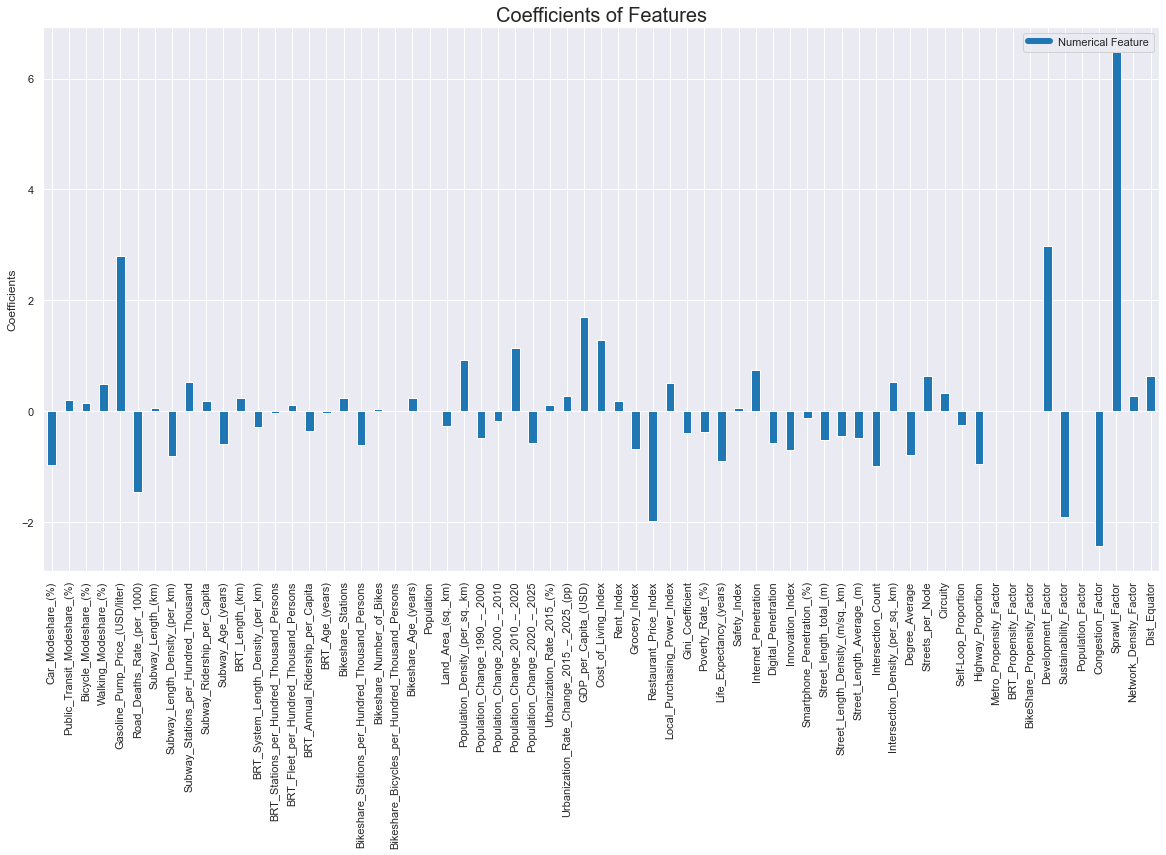

In [27]:
plot_coef(elastic_net_cv, X_train)

In [39]:
elastic_net_cv.best_estimator_.steps[-1][1].intercept_

array([7.48282131])

## Part 2: Prediction Challenge 2

In [41]:
X_test = X[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')] 
y_test = y[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')]

X_train = X[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')] 
y_train = y[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')]

In [42]:
colum_names = X_train.columns

no_info_column = [
    'City', 'cityID', 'clusterID', 'Country', 'Latitude', 'Longitude', 'Continent', 'Typology'
]

columns_with_nan = df.columns[df.isnull().any()].tolist()

remove_columns = no_info_column + columns_with_nan

categorical_columns = []

numerical_columns = [ column for column in colum_names if column not in remove_columns+categorical_columns ]


In [43]:
elastic_net_model = linear_model.ElasticNet(fit_intercept = True)

n1 = 50
n2 = 10
parameters = {
    'model__alpha': np.logspace(-5, 1, n1),
    'model__l1_ratio': np.linspace(0, 1, n2)
}

elastic_net_pibe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
    categorical_columns = categorical_columns
)


elastic_net_cv = cv(elastic_net_pibe, parameters, X_train, y_train, cf = 10)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1999s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1941s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    5.2s
[Parallel(n

In [44]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]

0.00868511373751352

In [45]:
elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

1.0

### Part 1.2 Coefficients Analysis

In [46]:
y_pred = elastic_net_cv.predict(X_test)
print('R2: ', r2_score(y_test, y_pred))

R2:  0.4969250313263778


## Part 3: Trying out other regression models

In [ ]:
X, y = split_target_and_predictors(
    data = df,
    target = 'CO2_Emissions_per_Capita_(metric_tonnes)',
    drop_cols = ['Pollution_Index_']
)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.25, shuffle = False)


colum_names = X_train.columns
no_info_column = ['City', 'cityID', 'clusterID', 'Country', 'Latitude', 'Longitude', 'Typology']

columsn_with_nan = ['Bicycle_Modeshare_(%)', 'Congestion_(%)', 'Congestion_AM_Peak_(%)',
       'Congestion_PM_Peak_(%)', 'Traffic_Index', 'Travel_Time_Index',
       'Inefficiency_Index', 'Unemployment_Rate_(%)', 'Cost_of_Living_Index',
       'Rent_Index', 'Grocery_Index', 'Restaurant_Price_Index',
       'Local_Purchasing_Power_Index', 'Poverty_Rate_(%)', 'Safety_Index',
       'Pollution_Index_']

remove_columns = no_info_column + columsn_with_nan

categorical_columns = ['Continent']

numerical_columns = [ column for column in colum_names if column not in remove_columns+categorical_columns ]


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import pickle

In [ ]:
models = {
    'GBR': {
        'model' : GradientBoostingRegressor(),
        'parameters' : {
            'model__n_estimators':[100, 200, 300, 400, 500], 
            'model__learning_rate': [0.1, 0.05, 0.02],
            'model__max_depth': [3], 
            'model__min_samples_leaf':[3], 
        }
    },
    'RFR' : {
        'model' : RandomForestRegressor(),
        'parameters' : {
            'model__max_depth': [10, 20, None],
            'model__min_samples_leaf': [2],
            'model__min_samples_split': [2, 5, 10],
            'model__n_estimators': [100, 150, 200, 250]
        }
    },
    'SGDR' : {
        'model' : SGDRegressor(),
        'parameters' : {
            'model__penalty': ['elasticnet'],
            'model__alpha': np.logspace(-5, 1, 20),
            'model__l1_ratio': np.linspace(0, 1, 10)
        }
    },
    'KNNR' : {
        'model' : KNeighborsRegressor(),
        'parameters' : {
            'model__n_neighbors': np.linspace(5, 30, 6, dtype=np.int),
            'model__weights': ['uniform', 'distance'],
        }
    },
    'SVR' : {
        'model' : SVR(),
        'parameters' : {
            'model__kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
            'model__C' : [1,5,10],
            'model__degree' : [3,8],
            'model__gamma' : ('auto','scale')
        },
    } 

}
for key in models:
    print('Fitting ', key)
    pipe = getPipe(
        model = models[key]['model'],
        numerical_columns = numerical_columns,
        categorical_columns = categorical_columns
    )
    pipe_cv = cv(pipe, models[key]['parameters'], X_train, y_train, cf = 10)
    
    y_pred = pipe_cv.predict(X_test)
    r2 =  r2_score(y_test, y_pred)

    models[key]['model_object'] = pipe_cv
    models[key]['r2'] = r2
    

In [ ]:
pickle.dump(models, open('models.pickle', 'wb'))

In [ ]:
# read models
saved_model = pickle.load(open('models.pickle','rb'))

In [ ]:
for model in saved_model:
    print(model, ' r2: ', saved_model[model]['r2'])

In [ ]:
plot_coef(elastic_net_cv, X_train)

## Using the external data

In [37]:
df_external = pd.read_csv(os.path.abspath('../data/Processed/GeoMet_imputed.csv'), index_col=0)

In [38]:
full_data = pd.merge(df, df_external, on = ['City', 'Country'])

In [39]:
X, y = split_target_and_predictors(
    data = full_data,
    target = 'CO2_Emissions_per_Capita_(metric_tonnes)',
    drop_cols = ['Pollution_Index_']
)

In [40]:
X_test = X[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')] 
y_test = y[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')]

X_train = X[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')] 
y_train = y[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')]

In [45]:
colum_names = X_train.columns

no_info_column = ['City', 'cityID', 'clusterID', 'Country', 'Latitude', 'Longitude', 'Typology', 'Continent']

columns_with_nan = full_data.columns[full_data.isnull().any()].tolist()
remove_columns = no_info_column + columns_with_nan

categorical_columns = []
numerical_columns = [ column for column in colum_names if column not in remove_columns+categorical_columns ]

In [46]:
elastic_net_model = linear_model.ElasticNet(fit_intercept = True)

n1 = 50
n2 = 10
parameters = {
    'model__alpha': np.logspace(-5, 1, n1),
    'model__l1_ratio': np.linspace(0, 1, n2)
}

elastic_net_pibe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
    categorical_columns = categorical_columns
)

elastic_net_cv = cv(elastic_net_pibe, parameters, X_train, y_train, cf = 10)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1145s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 276 

In [47]:
y_pred = elastic_net_cv.predict(X_test)
print('R2: ', r2_score(y_test, y_pred))

R2:  0.5282156402326368


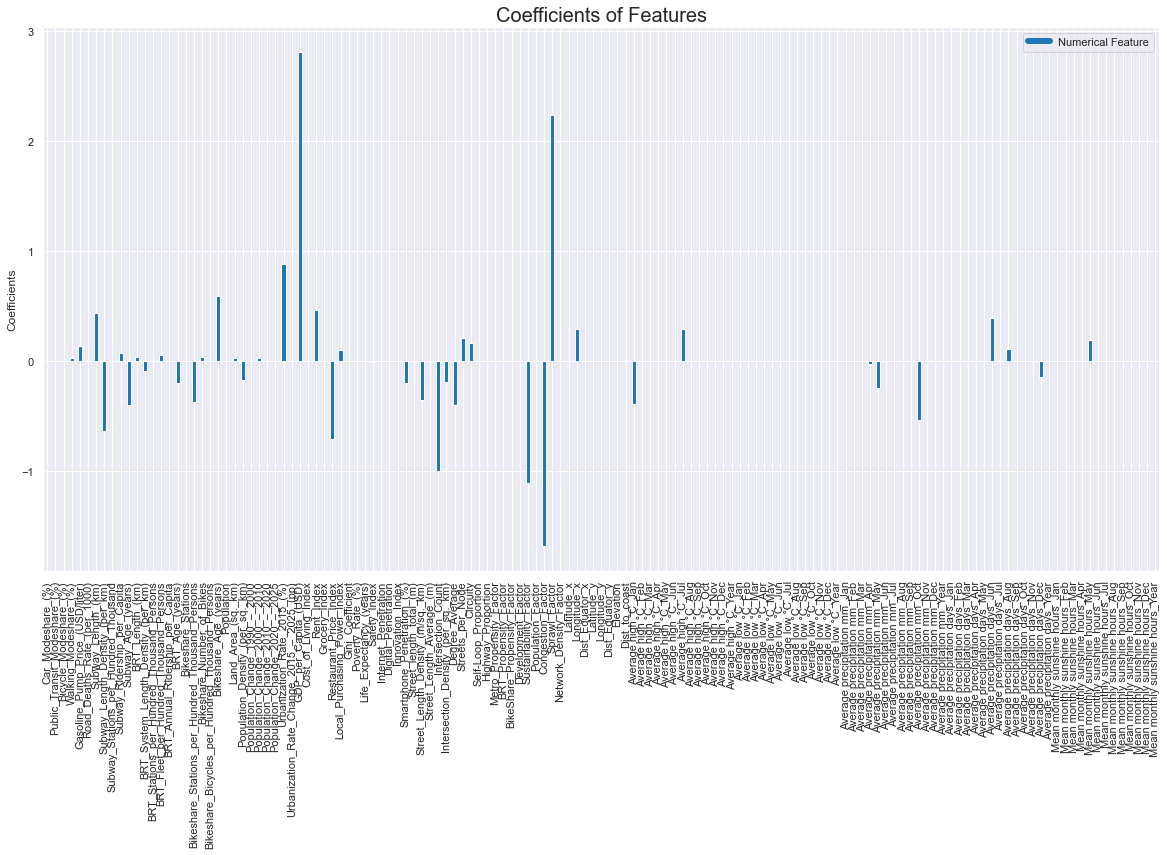

In [48]:
plot_coef(elastic_net_cv, X_train)